In [113]:
import numpy as np
from numba import njit

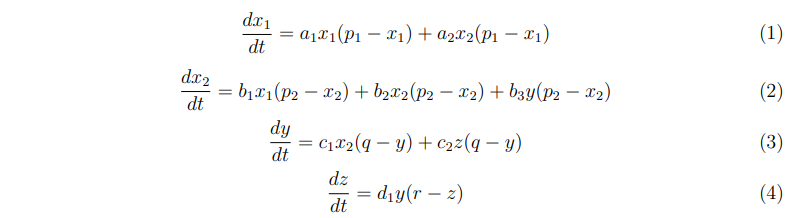

In [570]:
# Parameter dictionary
parameters = {
    # Constants
    "a1" : 10,
    "a2" : 5,
    "b1" : 5,
    "b2" : 1,
    "b3" : 1,
    "c1" : 1,
    "c2" : 1,
    "d1" : 1,

    # Population
    "p1" : 5,  # homosexual males
    "p2" : 5,  # bisexual males
    "q" : 100,  # heterosexual females
    "r" : 100, # heteroseual males
    "e" : 0.005, # transfusion rate

    "e_frac": 0,


    "r1": 0.1, # death rate
    "r2": 0.1, # death rate
    "r3": 0.1, # death rate
    "r4": 0.1, # death rate

    "with_transfusion": False,
    "with_frac": False,
    "with_death": False,
}


def update_frac(parameters, x1, x2, y, z):
    frac = (x1 + x2 + y + z)/(parameters["p1"] + parameters["p2"] + parameters["q"] + parameters["r"])
    parameters["e_frac"] = 10*frac

def get_equations(parameters):
    with_frac = parameters["with_frac"]
    with_transfusion = parameters["with_transfusion"]
    with_death = parameters["with_death"]


    a1 = parameters["a1"]
    a2 = parameters["a2"]
    b1 = parameters["b1"]
    b2 = parameters["b2"]
    b3 = parameters["b3"]
    c1 = parameters["c1"]
    c2 = parameters["c2"]
    d1 = parameters["d1"]

    p1 = parameters["p1"]
    p2 = parameters["p2"]
    q = parameters["q"]
    r = parameters["r"]
    e = parameters["e"] if not with_frac else parameters["e_frac"]

    r1 = parameters["r1"]
    r2 = parameters["r2"]
    r3 = parameters["r3"]
    r4 = parameters["r4"]

    # @njit
    def dx1_dt(x1, x2):
        return a1*x1*(p1-x1) + a2*x2*(p1-x1) + (e*(p1-x1) if with_transfusion else 0) - (r1*x1 if with_death else 0)
    # @njit
    def dx2_dt(x1, x2, y):
        return b1*x1*(p2-x2) + b2*x2*(p2-x2) + b3*y*(p2-x2) + (e*(p2-x2) if with_transfusion else 0) - (r2*x2 if with_death else 0)
    
    # @njit
    def dy_dt(x2, y, z):
        return c1*x2*(q-y) + c2*z*(q-y) + (e*(q-y) if with_transfusion else 0) - (r3*y if with_death else 0)
    
    # @njit
    def dz_dt(y, z):
        return d1*y*(r-z) + (e*(r-z) if with_transfusion else 0) - (r4*z if with_death else 0)
    

    return dx1_dt, dx2_dt, dy_dt, dz_dt
    


In [571]:
def get_stepfn(parameters, dt, mode):
    assert mode in ['euler', 'rk4'], 'mode must be either euler or rk4'

    dx1_dt, dx2_dt, dy_dt, dz_dt = get_equations(parameters)


    # @njit
    def step_euler(x1, x2, y, z):
        x1_new = x1 + dx1_dt(x1, x2)*dt
        x2_new = x2 + dx2_dt(x1, x2, y)*dt
        y_new  = y + dy_dt(x2, y, z)*dt
        z_new  = z + dz_dt(y, z)*dt
        return x1_new, x2_new, y_new, z_new
    
    # @njit
    def step_rk4(x1, x2, y, z):
        x1_new = x1 + dt*(dx1_dt(x1, x2) + 2*dx1_dt(x1, x2) + 2*dx1_dt(x1, x2) + dx1_dt(x1, x2))/6
        x2_new = x2 + dt*(dx2_dt(x1_new, x2, y) + 2*dx2_dt(x1_new, x2, y) + 2*dx2_dt(x1_new, x2, y) + dx2_dt(x1_new, x2, y))/6
        y_new = y + dt*(dy_dt(x2_new, y, z) + 2*dy_dt(x2_new, y, z) + 2*dy_dt(x2_new, y, z) + dy_dt(x2_new, y, z))/6
        z_new = z + dt*(dz_dt(y_new, z) + 2*dz_dt(y_new, z) + 2*dz_dt(y_new, z) + dz_dt(y_new, z))/6
        return x1_new, x2_new, y_new, z_new

    return step_euler if mode == 'euler' else step_rk4

# @njit
def do_simulation(stepfn, x1, x2, y, z, total_time, mode, dt):
    total_steps = int(total_time//dt + 1)
    x_axis = np.linspace(0, total_time, total_steps)

    data = np.empty((total_steps, 5))

    data[0] = [x1, x2, y, z, 0]
    data[:,4] = x_axis
    
    for i in range(1,total_steps):
        x1, x2, y, z = stepfn(x1, x2, y, z)
        data[i][:4] = [x1, x2, y, z]

        if parameters["with_frac"]:
            update_frac(parameters, x1, x2, y, z)
            stepfn = get_stepfn(parameters, dt, mode) # Not optimal, but works. Maybe TODO: use a refence to the parameters instead of the parameters themselves 

    return data


def simulate(parameters, x1, x2, y, z, total_time, mode = 'euler', dt = 0.001):
    stepfn = get_stepfn(parameters, dt, mode)
    data = do_simulation(stepfn, x1, x2, y, z, total_time, mode, dt)
    return data



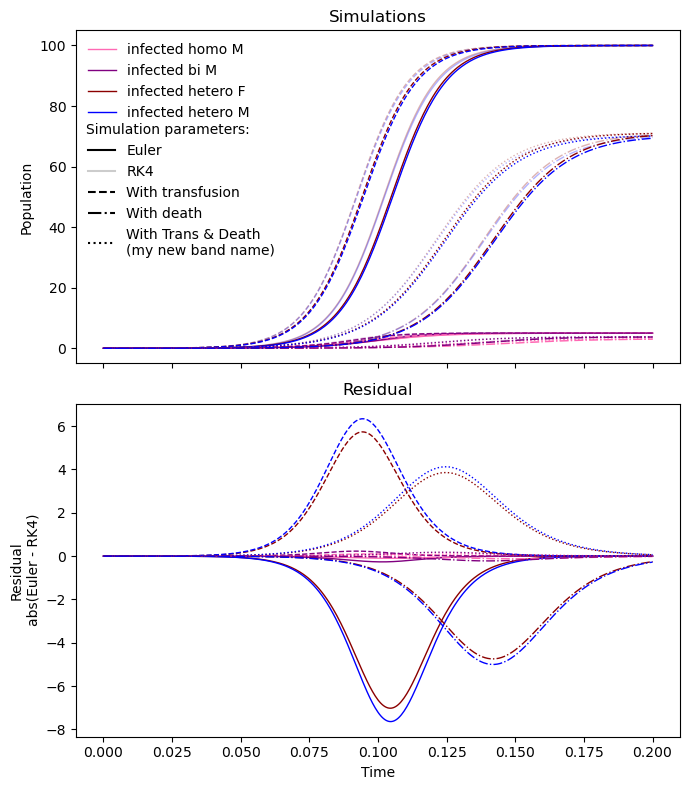

In [572]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib.legend import Legend


def plot_data(data, ax, label = False,**kwargs):
    x = data[:,4]
    ax.plot(x, data[:,0], label = 'infected homo M' if label else None,    color = "hotpink", linewidth = 1, **kwargs)
    ax.plot(x, data[:,1], label = 'infected bi M'  if label else None,     color = "purple",linewidth = 1, **kwargs)
    ax.plot(x, data[:,2], label = 'infected hetero F' if label else None,  color = "darkred",linewidth = 1, **kwargs)
    ax.plot(x, data[:,3], label = 'infected hetero M' if label else None,  color = "blue",linewidth = 1, **kwargs)


def compare(parameters, x1, x2, y, z, total_time, dt = 0.001):
    data_euler = simulate(parameters, x1, x2, y, z, total_time, mode = 'euler', dt = dt)
    data_rk4 = simulate(parameters, x1, x2, y, z, total_time, mode = 'rk4', dt = dt)

    parameters["with_transfusion"] = 1
    data_euler_trans = simulate(parameters, x1, x2, y, z, total_time, mode = 'euler', dt = dt)
    data_rk4_trans = simulate(parameters, x1, x2, y, z, total_time, mode = 'rk4', dt = dt)

    parameters["with_death"] = 1
    data_euler_trans_death = simulate(parameters, x1, x2, y, z, total_time, mode = 'euler', dt = dt)
    data_rk4_trans_death = simulate(parameters, x1, x2, y, z, total_time, mode = 'rk4', dt = dt)

    parameters["with_transfusion"] = 0
    data_euler_death = simulate(parameters, x1, x2, y, z, total_time, mode = 'euler', dt = dt)
    data_rk4_death = simulate(parameters, x1, x2, y, z, total_time, mode = 'rk4', dt = dt)


    x = data_euler[:,4]
    fig, axs = plt.subplots(2, 1, figsize=(7, 8), sharex=True)

    plot_data(data_rk4, axs[0], alpha = 0.3)

    plot_data(data_euler, axs[0], label=True)

    plot_data(data_rk4_trans, axs[0], ls = "--", alpha = 0.3)

    plot_data(data_euler_trans, axs[0], ls = "--")

    plot_data(data_rk4_trans_death, axs[0], ls = ":", alpha = 0.3)

    plot_data(data_euler_trans_death, axs[0], ls = ":")

    plot_data(data_rk4_death, axs[0], ls = "dashdot", alpha = 0.3)

    plot_data(data_euler_death, axs[0], ls = "dashdot")


    diffs = -np.abs(data_euler - data_rk4)
    diffs[:,4] = x
    plot_data(diffs, axs[1])

    diffs_trans = +np.abs(data_euler_trans - data_rk4_trans)
    diffs_trans[:,4] = x
    plot_data(diffs_trans, axs[1], ls = "--")

    diffs_trans_death = +np.abs(data_euler_trans_death - data_rk4_trans_death)
    diffs_trans_death[:,4] = x
    plot_data(diffs_trans_death, axs[1], ls = ":")

    diffs_death = -np.abs(data_euler_death - data_rk4_death)
    diffs_death[:,4] = x
    plot_data(diffs_death, axs[1], ls = "dashdot")


    axs[0].set_title('Simulations')
    axs[1].set_title('Residual')

    axs[0].legend(loc = "upper left", frameon=False)



    custom_lines = [Line2D([0], [0],color="white"),
                    Line2D([0], [0],color="black"),
                    Line2D([0], [0], color="black", alpha = 0.2),
                    Line2D([0], [0], color="black", ls = '--'),
                    Line2D([0], [0], color="black", ls = 'dashdot'),
                    Line2D([0], [0], color="black", ls = ':')]
        

    legend = Legend(axs[0],custom_lines, ["Simulation parameters:",'Euler', 'RK4', "With transfusion", "With death","With Trans & Death\n(my new band name)"], loc = (0.01,0.3), frameon=False)

    txt = legend.get_texts()[0]

    txt.set_position((-40,0))

    axs[1].set_xlabel('Time')
    axs[0].set_ylabel('Population')
    axs[1].set_ylabel('Residual\nabs(Euler - RK4)')

    axs[0].add_artist(legend)
    fig.tight_layout()

    return axs


x1 = 0.01   # infected homosexual males (p1)
x2 = 0    # infected bisexual males (p2)

y = 0  # infected heterosexual females (q)
z = 0  # infected heterosexual males (r)


parameters["with_transfusion"] = 0
parameters["with_frac"] = 0
parameters["with_death"] = 0

parameters["r1"] = 30
parameters["r2"] = 30
parameters["r3"] = 30
parameters["r4"] = 30
axs1 = compare(parameters, x1, x2, y, z, 0.2, dt = 0.0005)



(0.001, 110)

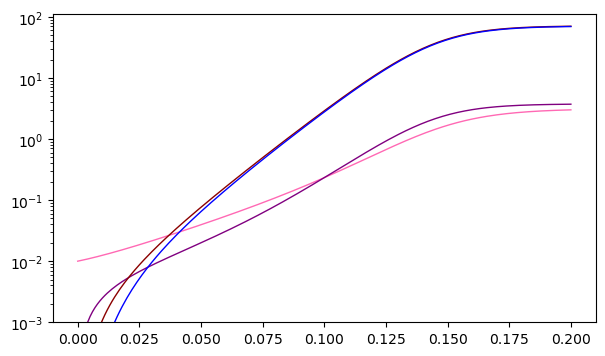

In [573]:
parameters["with_transfusion"] = False
parameters["with_frac"] = False
data = simulate(parameters, x1, x2, y, z, 0.2, mode = 'euler', dt = 0.001)
x = data[:,4]

# plt.plot(x, data, '-',label = f"no trans", color = "darkgreen", alpha = 1, linewidth = 0.7)
fig, axs = plt.subplots(1, 1, figsize=(7, 4), sharex=True) 
plot_data(data, axs)
plt.yscale("log")
plt.ylim(0.001, 110)

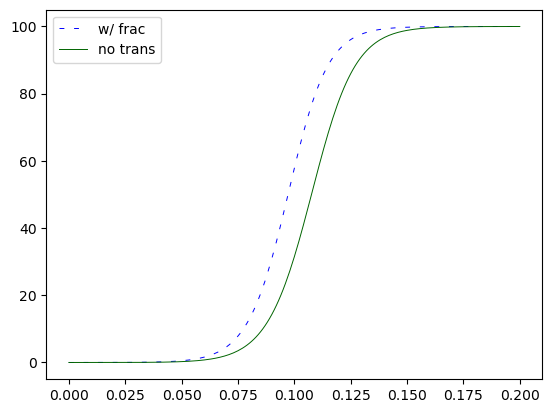

In [574]:
parameters["with_transfusion"] = True
parameters["with_frac"] = True
parameters["with_death"] = False

update_frac(parameters, x1, x2, y, z)
data = simulate(parameters, x1, x2, y, z, 0.2, mode = 'euler', dt = 0.001)
x = data[:,4]

plt.plot(x, data[:,3], label = f"w/ frac", color = "blue", ls = (0,(5,10)), alpha = 1, linewidth = 0.7)


parameters["with_transfusion"] = False
parameters["with_frac"] = False
data = simulate(parameters, x1, x2, y, z, 0.2, mode = 'euler', dt = 0.001)
x = data[:,4]

plt.plot(x, data[:,3], label = f"no trans", color = "darkgreen", alpha = 1, linewidth = 0.7)

plt.legend()


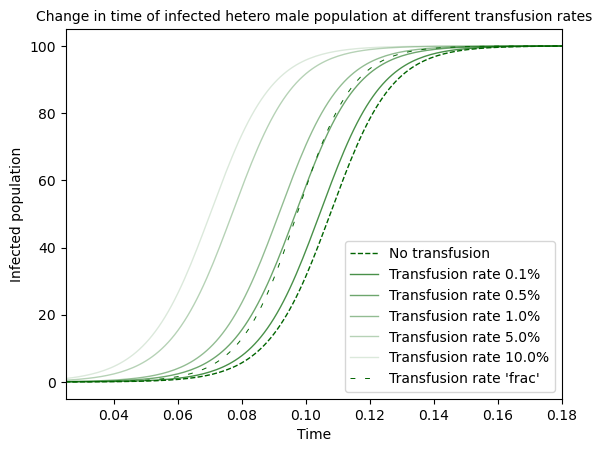

In [593]:
es = [0.001, 0.005, 0.01, 0.05, 0.1]

# plt.plot((0,0), (0,0), '-', label = "Infected hetero M", color = "white")
parameters["with_death"] = False


parameters["e"] = 0
parameters["with_transfusion"] = False
parameters["with_frac"] = False
data = simulate(parameters, x1, x2, y, z, 0.2, mode = 'euler', dt = 0.001)
x = data[:,4]

plt.plot(x, data[:,3], '--',label = f'No transfusion', color = "darkgreen", alpha = 1, linewidth = 1)


for i, e in enumerate(es):
    parameters["e"] = e
    parameters["with_transfusion"] = True
    parameters["with_frac"] = False
    data = simulate(parameters, x1, x2, y, z, 0.2, mode = 'euler', dt = 0.001)
    x = data[:,4]
    plt.plot(x, data[:,3], '-',label = f'Transfusion rate {e*100:.3}%', color = "darkgreen", alpha = 1- (i + 2)/(len(es)+2), linewidth = 1)


update_frac(parameters, x1, x2, y, z)
parameters["with_transfusion"] = True
parameters["with_frac"] = True
data = simulate(parameters, x1, x2, y, z, 0.2, mode = 'euler', dt = 0.001)
x = data[:,4]
plt.plot(x, data[:,3],label = f"Transfusion rate 'frac'", color = "darkgreen", ls = (0,(5,10)), alpha = 1, linewidth = 0.7)


plt.legend()
plt.xlabel("Time")
plt.ylabel("Infected population")
plt.title("Change in time of infected hetero male population at different transfusion rates", fontsize = 10)

plt.xlim(0.025,0.18)

plt.show()
    

In [ ]:
parameters["r1"] = 30
parameters["r2"] = 30
parameters["r3"] = 30
parameters["r4"] = 30

In [345]:
print(x1, x2, y, z)

print(parameters.values())


0.01 0 0 0
dict_values([10, 5, 5, 1, 1, 1, 1, 1, 5, 5, 100, 100, 0.01, 4, 0, 0, 0, 0, 0, True, False, True])


In [391]:
dts = [0.01, 0.005, 0.001, 0.0005, 0.0002]
eulers = []
rk4s = []
parameters["with_transfusion"] = True
parameters["with_death"] = True
parameters["e"] = 0.01
ground_truth = simulate(parameters, x1, x2, y, z, 0.3, mode = 'rk4', dt =   0.000001)

for dt in dts:

    data_euler = simulate(parameters, x1, x2, y, z, 0.3, mode = 'euler', dt = dt)
    data_rk4 = simulate(parameters, x1, x2, y, z, 0.3, mode = 'rk4', dt = dt)
    eulers.append(data_euler)
    rk4s.append(data_rk4)


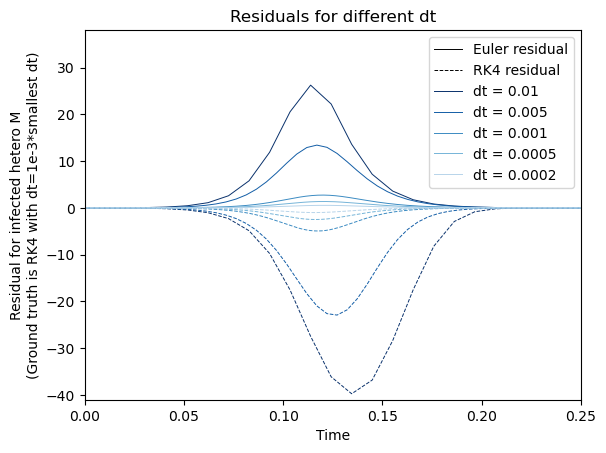

In [606]:
def find_index_of_closest_point_in_array(num, arr):
    return np.abs(arr - num).argmin()



# red color gradient of same length as dts
colors = zip(*[plt.cm.Greens(np.linspace(0.3,1,len(dts))), plt.cm.Blues(np.linspace(0.3,1,len(dts)))[::-1]])

plt.plot((0,0), (0,0), '-', label = "Euler residual", color = "black", linewidth = 0.7)
plt.plot((0,0), (0,0), '--', label = "RK4 residual", color = "black", linewidth = 0.7)
for (eul, rk4, dt, c) in zip(eulers, rk4s, dts, colors):
    # get the ground trith for the given dt

    x = eul[:,4]

    # pick out so they have same length
    ground_truth_dt = []
    for xx in x:
        ground_truth_dt.append(ground_truth[find_index_of_closest_point_in_array(xx, ground_truth[:,4])])
    
    ground_truth_dt = np.array(ground_truth_dt)

    plt.plot(x, (eul[:,3] - ground_truth_dt[:,3]), '--',  color = c[1], linewidth = 0.7)
    plt.plot(x, (rk4[:,3] - ground_truth_dt[:,3]), label = f"dt = {dt}", color = c[1], linewidth = 0.7)



plt.xlim(0,0.25)
plt.ylim(-41,38)
# plt.yscale("log")
plt.legend(loc = "upper right", fancybox = True)
plt.ylabel("Residual for infected hetero M\n(Ground truth is RK4 with dt=1e-3*smallest dt)")
plt.xlabel("Time")
plt.title("Residuals for different dt")

plt.show()
